Copyright 2020 The Google Research Authors. All Rights Reserved.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**NOTE: Executing the code (training or evaluation) for the first time will download the full CLEVR dataset (17.7GB).**

In [1]:
# Requirements: Python 3.x, TensorFlow 2.x, TensorFlow Datasets

from absl import logging
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# When executing this notebook out of a subfolder, use the command below to
# change to the project's root folder (required for imports):
# %cd ..

# import data as data_utils
import model as model_utils
import data as data_utils

2025-02-16 22:10:53.259873: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 22:10:53.272724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739736653.284402    3484 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739736653.288462    3484 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 22:10:53.305361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Hyperparameters.
seed = 10
batch_size = 1
num_slots = 7
num_iterations = 3
resolution = (128, 128)
ckpt_path = "slot_attention/object_discovery/checkpoints"  # Path to model checkpoint.

In [3]:
def load_model(checkpoint_dir, num_slots=11, num_iters=3, batch_size=16):
  resolution = (128, 128)
  model = model_utils.build_model(
      resolution, batch_size, num_slots, num_iters,
      model_type="object_discovery")

  ckpt = tf.train.Checkpoint(network=model)
  ckpt_manager = tf.train.CheckpointManager(
      ckpt, directory=checkpoint_dir, max_to_keep=5)

  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    logging.info("Restored from %s", ckpt_manager.latest_checkpoint)

  return model

In [4]:
# Build dataset iterators, optimizers and model.
tf.random.set_seed(seed)
data_iterator = data_utils.build_npy_iterator(
    '1000_nopick_pixel_states.npy', batch_size, split="train", resolution=resolution, shuffle=True,
    apply_augmentation=True
)

model = load_model(ckpt_path, num_slots=num_slots, num_iters=num_iterations,
                   batch_size=batch_size)

I0000 00:00:1739736658.260259    3484 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6724 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 2. + 0.5

def get_prediction(model, batch, idx=0):
  recon_combined, recons, masks, slots = model(batch["image"])
  image = renormalize(batch["image"])[idx]
  recon_combined = renormalize(recon_combined)[idx]
  recons = renormalize(recons)[idx]
  masks = masks[idx]
  return image, recon_combined, recons, masks, slots

In [6]:
# Get new batch.
batch = next(data_iterator)

In [7]:
# Predict.
image, recon_combined, recons, masks, slots = get_prediction(model, batch)

I0000 00:00:1739736698.013994    3484 cuda_dnn.cc:529] Loaded cuDNN version 90300


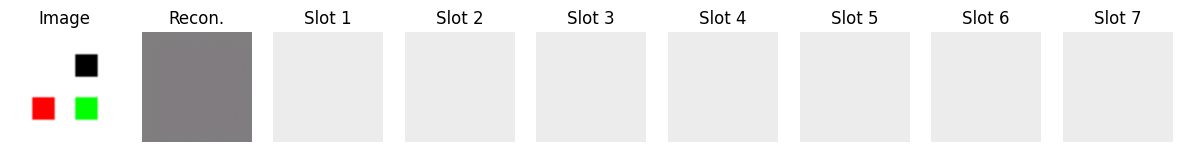

In [8]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(num_slots):
  ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')